In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

In [2]:
df = pd.read_csv('exchange_rate.csv')

In [3]:
df.columns

Index(['date', 'Ex_rate'], dtype='object')

In [4]:
date_col = df.columns[0]

In [5]:
target_col = df.columns[1]

In [6]:
print("Using date column:", date_col, "and target column:", target_col)

Using date column: date and target column: Ex_rate


In [7]:
# Parse dates and set index
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

In [8]:
df = df.set_index(date_col).sort_index()

In [9]:
series = df[target_col].astype(float).copy()

In [11]:
series.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [12]:
series.isna().sum()

np.int64(0)

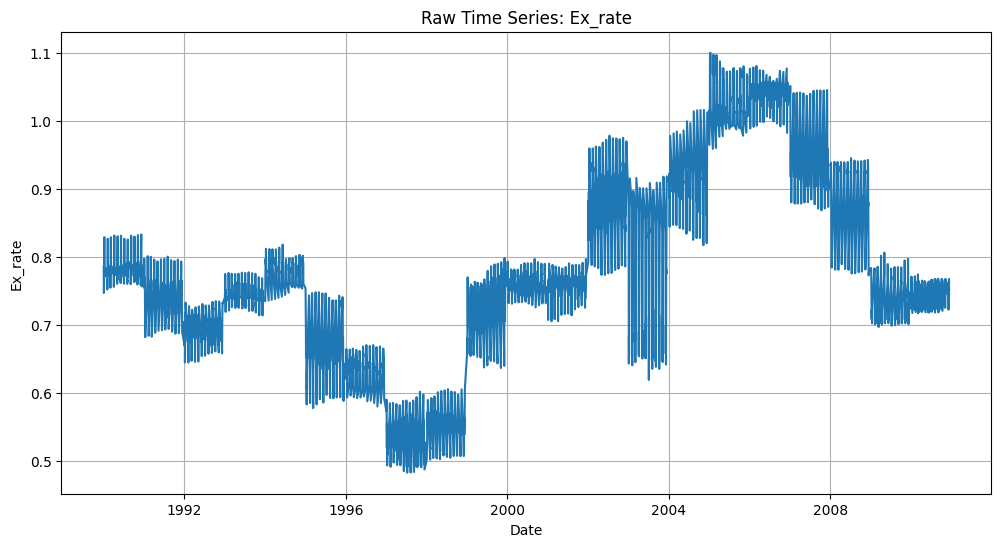

In [32]:
def plot_series(series, test=None, title=None, ylabel=None):
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Train')
    if test is not None:
        plt.plot(test, label='Test')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.grid(True)
    if test is not None:
        plt.legend()
    plt.show()

# Plot raw series (original call, which will now use the updated function)
plot_series(series, title=f"Raw Time Series: {target_col}", ylabel=target_col)

In [16]:
# Try to infer frequency
inferred_freq = pd.infer_freq(series.index)
print("Inferred frequency:", inferred_freq)


Inferred frequency: None


In [17]:
# STL decomposition — use a reasonable period (fallback to 12)
period = 12
if inferred_freq is not None:
    if 'M' in inferred_freq:
        period = 12
    elif 'W' in inferred_freq:
        period = 52
    elif 'D' in inferred_freq:
        period = 7
print("Using STL period:", period)

Using STL period: 12


STL failed (irregular freq?) - Axis limits cannot be NaN or Inf


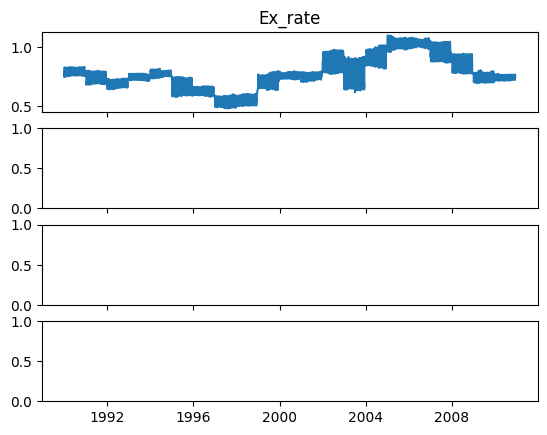

In [18]:
# Fill very small missing values for decomposition if present
ser_decomp = series.fillna(method='ffill').fillna(method='bfill')
try:
    stl = STL(ser_decomp, period=period)
    res = stl.fit()
    fig = res.plot()
    fig.set_size_inches(10,8)
    plt.suptitle("STL Decomposition")
    plt.show()
except Exception as e:
    print("STL failed (irregular freq?) -", e)

In [20]:
# Simple outlier detection
rolling_mean = series.rolling(window=12, min_periods=1).mean()
rolling_std = series.rolling(window=12, min_periods=1).std().replace(0, np.nan)
zscore = (series - rolling_mean) / rolling_std
outliers = zscore[abs(zscore) > 3]
print("Detected outliers (z-score > 3):", len(outliers))

Detected outliers (z-score > 3): 6


In [22]:
if len(outliers) > 0:
    print(outliers.head())

date
NaT    3.135719
NaT    3.063453
NaT    3.028691
NaT    3.145876
NaT   -3.131003
Name: Ex_rate, dtype: float64


In [24]:
# Strategy: time interpolation for missing values, winsorize extremes (1st/99th percentile)
# First, remove rows where the index is NaT to allow time-based interpolation
series_preproc = series[series.index.notna()]
series_preproc = series_preproc.interpolate(method='time').fillna(method='bfill').fillna(method='ffill')
low, high = series_preproc.quantile([0.01, 0.99])
series_preproc = series_preproc.clip(lower=low, upper=high)

In [25]:
print("\nAfter preprocessing: missing values:", series_preproc.isna().sum())


After preprocessing: missing values: 0


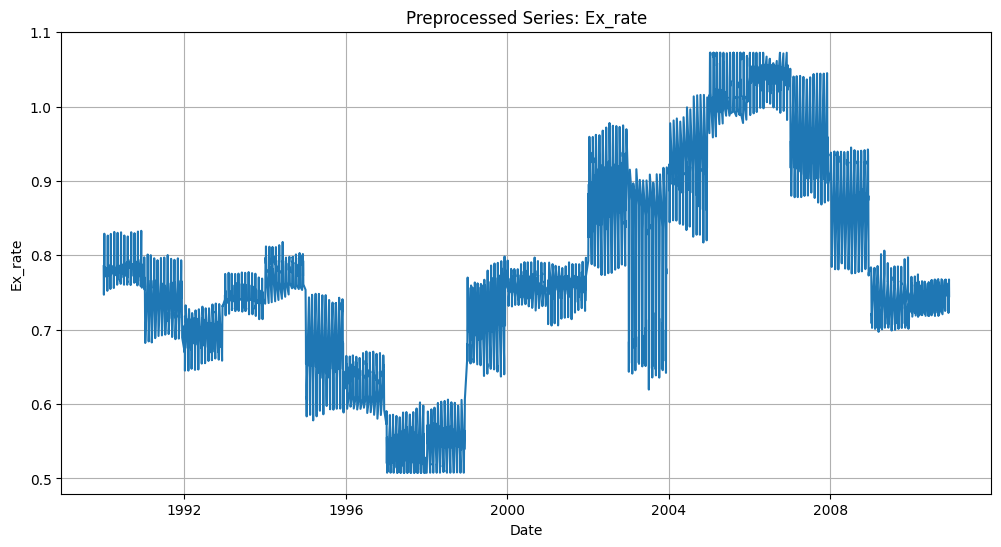

In [26]:
plot_series(series_preproc, title=f"Preprocessed Series: {target_col}", ylabel=target_col)


In [28]:
# ---------------- Train-test split ----------------
n = len(series_preproc)
if n >= 36:
    test_size = 12
else:
    test_size = max(1, int(0.2 * n))
train = series_preproc.iloc[:-test_size]
test = series_preproc.iloc[-test_size:]

In [29]:
print(f"\nTotal points: {n}; Train: {len(train)}; Test: {len(test)}")


Total points: 2998; Train: 2986; Test: 12


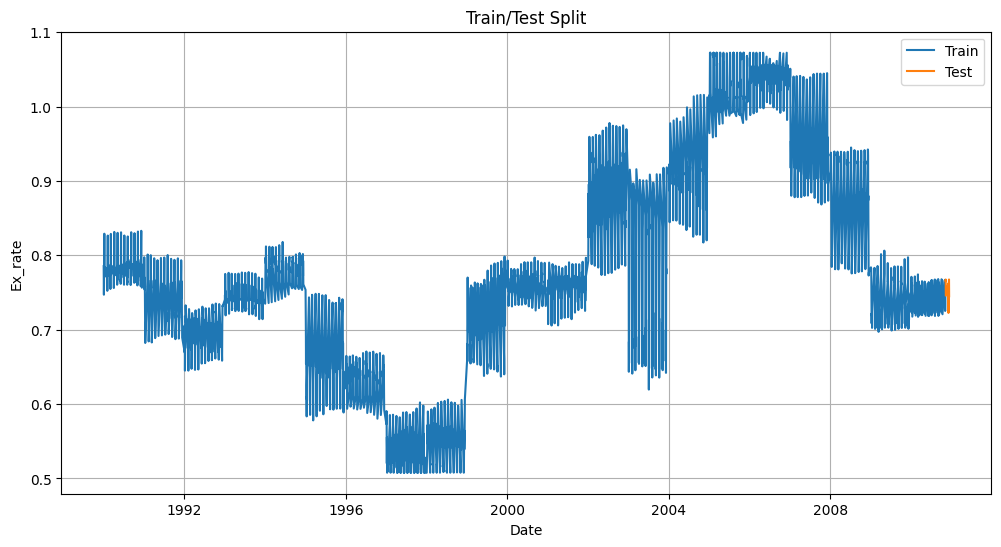

In [33]:
plot_series(train, test=test, title="Train/Test Split", ylabel=target_col)

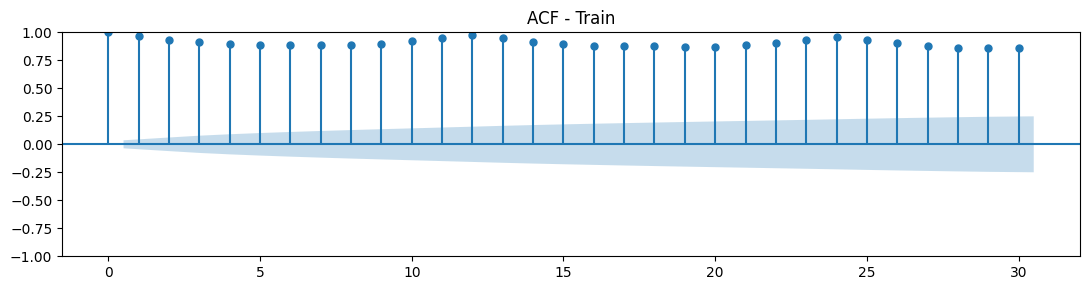

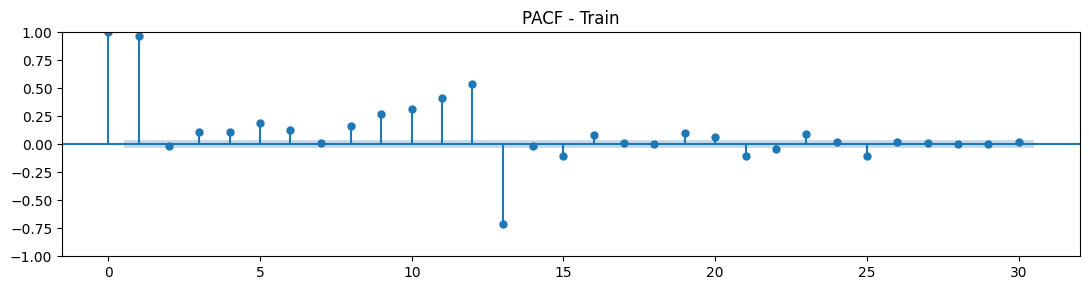

In [35]:
# ---------------- Part 2: ARIMA - ACF/PACF ----------------
plt.figure(figsize=(11,3)); plot_acf(train, lags=30, ax=plt.gca()); plt.title("ACF - Train"); plt.tight_layout(); plt.show()
plt.figure(figsize=(11,3)); plot_pacf(train, lags=30, ax=plt.gca(), method='ywm'); plt.title("PACF - Train"); plt.tight_layout(); plt.show()

In [42]:
# Grid search for ARIMA (kept compact to avoid very long runs)
p_range = range(0,3)  # p = 0,1,2
d_range = range(0,2)  # d = 0,1
q_range = range(0,3)  # q = 0,1,2

In [43]:
best_aic = np.inf
best_order = None
best_res = None

In [44]:
print("\nStarting ARIMA grid search (compact ranges). This may take some time depending on data length.")
for p in p_range:
    for d in d_range:
        for q in q_range:
            try:
                model = SARIMAX(train, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
                res_model = model.fit(disp=False, maxiter=50, method='lbfgs')
                if res_model.aic < best_aic:
                    best_aic = res_model.aic
                    best_order = (p,d,q)
                    best_res = res_model
            except Exception:
                continue


Starting ARIMA grid search (compact ranges). This may take some time depending on data length.


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [45]:
print("Best ARIMA order by AIC:", best_order, "AIC:", best_aic)

Best ARIMA order by AIC: (2, 1, 2) AIC: -12160.335691048891


In [50]:
if best_res is not None:
    print("\nARIMA summary:")
    print(best_res.summary())
    resid = best_res.resid.dropna()



ARIMA summary:
                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 2986
Model:               SARIMAX(2, 1, 2)   Log Likelihood                6085.168
Date:                Thu, 20 Nov 2025   AIC                         -12160.336
Time:                        13:08:35   BIC                         -12130.334
Sample:                             0   HQIC                        -12149.541
                               - 2986                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3730      0.028     48.274      0.000       1.317       1.429
ar.L2         -0.6355      0.019    -32.860      0.000      -0.673      -0.598
ma.L1         -2.0600     19.427    

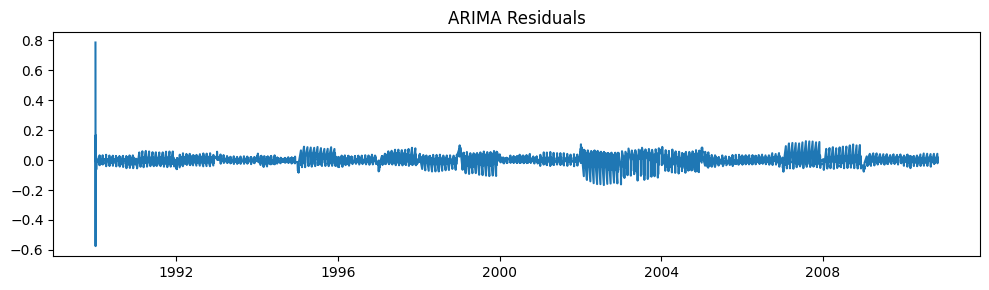

In [51]:
plt.figure(figsize=(10,3)); plt.plot(resid); plt.title("ARIMA Residuals"); plt.tight_layout(); plt.show()

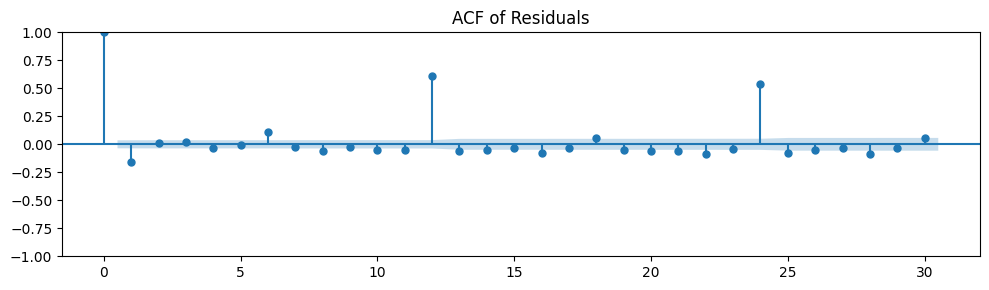

In [52]:
plt.figure(figsize=(10,3)); plot_acf(resid, lags=30, ax=plt.gca()); plt.title("ACF of Residuals"); plt.tight_layout(); plt.show()

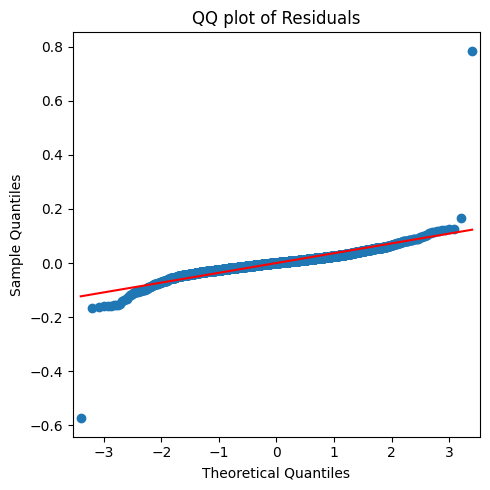

In [53]:
plt.figure(figsize=(5,5)); sm.qqplot(resid, line='s', ax=plt.gca()); plt.title("QQ plot of Residuals"); plt.tight_layout(); plt.show()

In [55]:
# Forecast
steps = len(test)
fc = best_res.get_forecast(steps=steps)
arima_pred = pd.Series(fc.predicted_mean.values, index=test.index)
conf_int = fc.conf_int(alpha=0.05)
lower = pd.Series(conf_int.iloc[:,0].values, index=test.index)
upper = pd.Series(conf_int.iloc[:,1].values, index=test.index)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


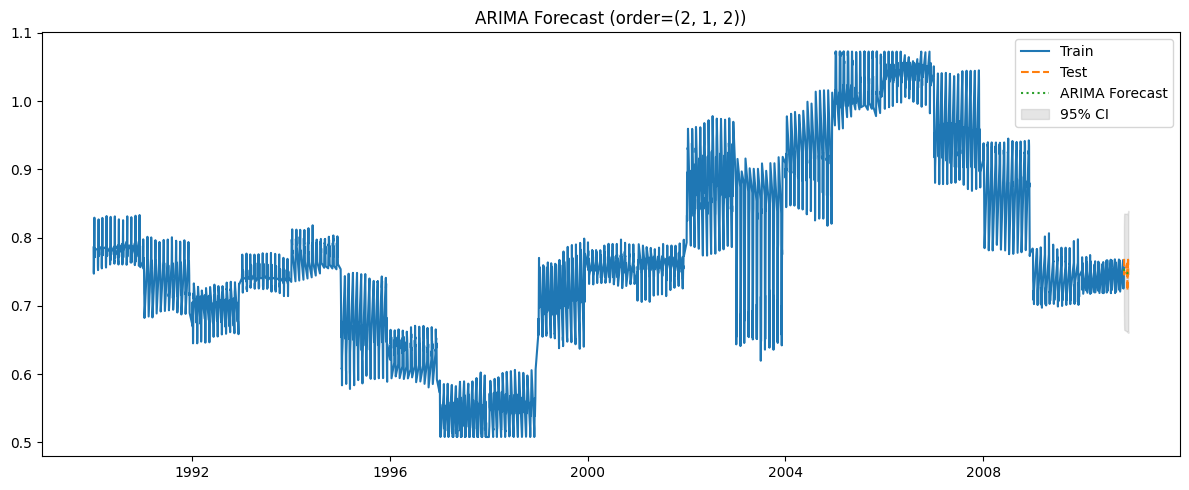

In [57]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test', linestyle='--')
plt.plot(arima_pred.index, arima_pred.values, label='ARIMA Forecast', linestyle=':')
plt.fill_between(test.index, lower, upper, color='gray', alpha=0.2, label='95% CI')
plt.title(f'ARIMA Forecast (order={best_order})')
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

if best_res is not None:
    arima_mae = mean_absolute_error(test, arima_pred)
    # Calculate RMSE manually as `squared` argument might not be available in all sklearn versions
    arima_rmse = np.sqrt(mean_squared_error(test, arima_pred))
    arima_mape = mape(test, arima_pred)
    print(f"ARIMA -> MAE: {arima_mae:.6f}, RMSE: {arima_rmse:.6f}, MAPE: {arima_mape:.3f}%")
else:
    print("ARIMA model didn't converge for the tried orders.")
    arima_mae = arima_rmse = arima_mape = np.nan

ARIMA -> MAE: 0.010921, RMSE: 0.012948, MAPE: 1.448%


In [63]:
seasonal_candidates = [None, 6, 12]
trend_options = [None, 'add']
seasonal_options = [None, 'add']

In [64]:
best_es_aic = np.inf
best_es_res = None
best_es_cfg = None

In [87]:
print("\nStarting Exponential Smoothing grid search (compact).")

# Ensure train series has a defined frequency for statsmodels forecasting
train_es = train.asfreq('D')
train_es = train_es.fillna(method='ffill').fillna(method='bfill') # Fill any NaNs introduced by asfreq

for trend in trend_options:
    for seasonal in seasonal_options:
        for sp in seasonal_candidates:
            # skip incompatible configs
            if seasonal is not None and sp is None:
                continue
            try:
                model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=sp, initialization_method="estimated")
                res = model.fit(optimized=True)
                aic_val = getattr(res, "aic", np.inf)
                if aic_val < best_es_aic:
                    best_es_aic = aic_val
                    best_es_res = res
                    best_es_cfg = (trend, seasonal, sp)
            except Exception:
                continue


Starting Exponential Smoothing grid search (compact).


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [88]:
print("Best Exponential Smoothing config:", best_es_cfg, "AIC:", best_es_aic)

Best Exponential Smoothing config: (None, None, None) AIC: -58075.73736259769


In [89]:
if best_es_res is not None:
    es_pred = pd.Series(best_es_res.forecast(steps=len(test)), index=test.index)

    if es_pred.isnull().any():
        print("Exponential Smoothing forecast contains NaNs. Skipping metric calculation.")
        es_mae = es_rmse = es_mape = np.nan
    else:
        plt.figure(figsize=(12,5))
        plt.plot(train.index, train.values, label='Train')
        plt.plot(test.index, test.values, label='Test', linestyle='--')
        plt.plot(es_pred.index, es_pred.values, label='Exponential Smoothing Forecast', linestyle='-.')
        plt.title(f"Exponential Smoothing Forecast (cfg={best_es_cfg})")
        plt.legend()
        plt.tight_layout()
        plt.show()

        es_mae = mean_absolute_error(test, es_pred)
        # Calculate RMSE manually as `squared` argument might not be available in all sklearn versions
        es_rmse = np.sqrt(mean_squared_error(test, es_pred))
        es_mape = mape(test, es_pred)
        print(f"ExpSmoothing -> MAE: {es_mae:.6f}, RMSE: {es_rmse:.6f}, MAPE: {es_mape:.3f}%")
else:
    print("Exponential Smoothing did not fit for the tried configs.")
    es_mae = es_rmse = es_mape = np.nan

Exponential Smoothing forecast contains NaNs. Skipping metric calculation.


In [90]:
results_df = pd.DataFrame({
    "Model": ["ARIMA", "ExpSmoothing"],
    "MAE": [arima_mae, es_mae],
    "RMSE": [arima_rmse, es_rmse],
    "MAPE (%)": [arima_mape, es_mape]
})

In [92]:
print("\nEvaluation results:")
print(results_df.to_string(index=False))


Evaluation results:
       Model      MAE     RMSE  MAPE (%)
       ARIMA 0.010921 0.012948  1.447565
ExpSmoothing      NaN      NaN       NaN


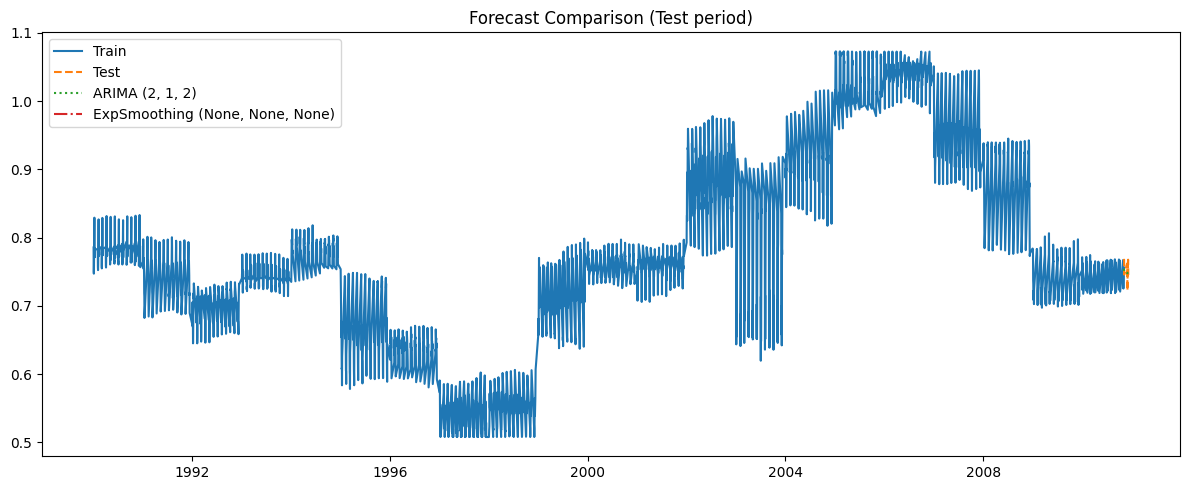

In [93]:
# Overlay comparison plot
plt.figure(figsize=(12,5))
plt.plot(train.index, train.values, label='Train')
plt.plot(test.index, test.values, label='Test', linestyle='--')
if 'arima_pred' in locals():
    plt.plot(arima_pred.index, arima_pred.values, label=f'ARIMA {best_order}', linestyle=':')
if 'es_pred' in locals():
    plt.plot(es_pred.index, es_pred.values, label=f'ExpSmoothing {best_es_cfg}', linestyle='-.')
plt.title("Forecast Comparison (Test period)")
plt.legend()
plt.tight_layout()
plt.show()

In [94]:
print("\nNotes:")
print("- Compare MAE / RMSE / MAPE to decide which model performs better on the test set.")
print("- Look at residual ACF and QQ plots for ARIMA to verify residual whiteness and normality assumptions.")
print("- If seasonality is strong and regular, Holt-Winters (ExponentialSmoothing with seasonal) often performs well.")
print("- ARIMA can capture more complex autocorrelation structures but needs proper d (differencing) and parameter tuning.")


Notes:
- Compare MAE / RMSE / MAPE to decide which model performs better on the test set.
- Look at residual ACF and QQ plots for ARIMA to verify residual whiteness and normality assumptions.
- If seasonality is strong and regular, Holt-Winters (ExponentialSmoothing with seasonal) often performs well.
- ARIMA can capture more complex autocorrelation structures but needs proper d (differencing) and parameter tuning.
